In [28]:
import pandas as pd
import torch
import random
import numpy as np
import gc

from tqdm import tqdm
from torch.utils.data import TensorDataset
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

References:
- https://medium.com/mlearning-ai/twitter-sentiment-analysis-with-deep-learning-using-bert-and-hugging-face-830005bcdbbf
- https://www.kdnuggets.com/2022/01/finetuning-bert-tweets-classification-ft-hugging-face.html

## Data Loading
First, we must load the data from the CSV files. The data is from a [Kaggle dataset](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification), so it was originally splitted into train and test. Therefore, we will concat both training and test sets to get an unique dataset.

In [2]:
train = pd.read_csv('Corona_NLP_train.csv', encoding = "ISO-8859-1")
test = pd.read_csv('Corona_NLP_test.csv', encoding = "ISO-8859-1")

df = pd.concat([train, test], axis=0)
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


## Exploratory Data Analysis

Let's check the categories distribution

In [3]:
df['Sentiment'].value_counts() / len(df)

Positive              0.275142
Negative              0.243755
Neutral               0.185341
Extremely Positive    0.160672
Extremely Negative    0.135091
Name: Sentiment, dtype: float64

The dataset is not pretty imbalanced. Considering that there are 5 categories, each category should represent a 20% of the data to be equally balanced. In this case, the less frequent category represent a 13% of the data. 

Let's encode the classes into integers. The categories are ordered from negative to positive.

In [4]:
label_dict = {
    'Extremely Negative': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
    'Extremely Positive': 4
}

df['Sentiment'] = df['Sentiment'].replace(label_dict)
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,3
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,3
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,3
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,3
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,1
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,2
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,0


The maximum number of characters allowed into a tweet is 280. We are going to check the tweets lenght, in order to analyze the data contained into the tweets.

In [1]:
df['lenght'] = df['OriginalTweet'].apply(lambda x: len(x))
df

NameError: name 'df' is not defined

<AxesSubplot:>

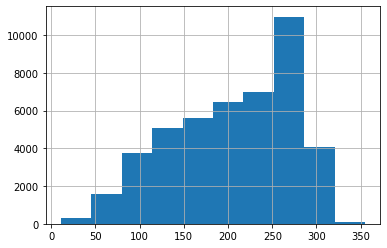

In [6]:
df['lenght'].hist()

In [7]:
df['lenght'].max()

355

There are several tweets with a length longer than 280, let's analyze one of these examples:

In [8]:
df[df['lenght'] > 300]['OriginalTweet'].values[0]

"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j"

As shown above, the tween contains several carriage return characters `\r` and a URL at the end. It also contains some uppercase letters.  
The tokenization will take care of that errors.

## Train Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df,
                                                   df['Sentiment'].values,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=df['Sentiment'])

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y_train)

In [10]:
X_train = X_train.drop('Sentiment', axis=1)
X_test = X_test.drop('Sentiment', axis=1)
X_val = X_val.drop('Sentiment', axis=1)

## Tokenization

We are going to use a pretrained `BertTokenizer`, given that we will use a BERT model to solve the task.

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case=True)

In [12]:
encoded_data_train = tokenizer.batch_encode_plus(X_train.OriginalTweet.values,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 280,
                                                return_tensors = 'pt')

encoded_data_val = tokenizer.batch_encode_plus(X_val.OriginalTweet.values,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 280,
                                                return_tensors = 'pt')

encoded_data_test = tokenizer.batch_encode_plus(X_test.OriginalTweet.values,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 280,
                                                return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [13]:
# Train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train)

# Validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val)

# Test set
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(y_test)

## Set up Model

In [14]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [15]:
# train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

# validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

# test set
dataset_test = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [16]:
batch_size = 32

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size,
                              num_workers=4)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32, #since we don't have to do backpropagation for this step
                            num_workers=4)
# test set
dataloader_test = DataLoader(dataset_test,
                              sampler = RandomSampler(dataset_test),
                              batch_size = 32, #since we don't have to do backpropagation for this step
                             num_workers=4)

In [17]:
optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8)
                 
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)

In [23]:
def evaluate(dataloader : DataLoader, model : BertForSequenceClassification):
    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader):
        
        #load into GPU
        batch = tuple(b.to('cuda') for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader) 
    
    predictions = np.concatenate(predictions, axis=0).argmax(1)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

def train(
    model : BertForSequenceClassification,
    train_loader : DataLoader,
    val_loader : DataLoader,
    optimizer : torch.optim.Optimizer,
    epochs : int
):
    for epoch in range(1, epochs+1):
    
        model.train()
        model.to('cuda')

        loss_train_total = 0

        predictions, true_vals = [], []

        for batch in tqdm(train_loader, desc = 'Epoch {:1d}'.format(epoch)):

            model.zero_grad()
            optimizer.zero_grad() #set gradient to 0

            batch = tuple(b.to('cuda') for b in batch)

            inputs = {'input_ids': batch[0], 
                      'attention_mask': batch[1], 
                      'labels': batch[2]}

            outputs = model(**inputs) #unpack the dict straight into inputs

            loss = outputs[0]
            loss_train_total += loss.item()
            loss.backward()

            #compute accuracy
            logits = outputs[1].detach().cpu().numpy()
            label_ids = inputs['labels'].cpu().numpy()
            predictions.append(logits)
            true_vals.append(label_ids)

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()
            #progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
        predictions = np.concatenate(predictions, axis=0).argmax(1)
        true_vals = np.concatenate(true_vals, axis=0)
        train_acc = accuracy_score(true_vals, predictions)

        torch.save(model.state_dict(), f'models/BERT_ft_epoch{epoch}.model')

        tqdm.write('\n Epoch {epoch}')

        loss_train_ave = loss_train_total / len(train_loader)
        tqdm.write(f'Training loss: {loss_train_ave}')
        tqdm.write(f'Training accuracy: {train_acc}')

        val_loss, predictions, true_vals = evaluate(val_loader, model)
        val_acc = accuracy_score(true_vals, predictions)
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'Val accuracy: {val_acc}')
        
        gc.collect()

In [19]:
def fix_seed():
    seed_val = 17
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    
fix_seed()

In [20]:
train()

Epoch 1: 100%|██████████| 900/900 [10:34<00:00,  1.42it/s]



 Epoch {epoch}
Training loss: 1.1100105405516094
Training loss: 0.5338013972402766


100%|██████████| 225/225 [00:54<00:00,  4.11it/s]


Validation loss: 0.7877477218045129
Val accuracy: 0.6785763937161129


Epoch 2: 100%|██████████| 900/900 [10:35<00:00,  1.42it/s]



 Epoch {epoch}
Training loss: 0.6480705485741297
Training loss: 0.7577421709360119


100%|██████████| 225/225 [00:54<00:00,  4.10it/s]


Validation loss: 0.5963524097204208
Val accuracy: 0.7789517586542472


Epoch 3: 100%|██████████| 900/900 [10:34<00:00,  1.42it/s]



 Epoch {epoch}
Training loss: 0.4661544943518109
Training loss: 0.8342080567237844


100%|██████████| 225/225 [00:54<00:00,  4.12it/s]


Validation loss: 0.5509327858686447
Val accuracy: 0.8007785346865007


Epoch 4: 100%|██████████| 900/900 [10:33<00:00,  1.42it/s]



 Epoch {epoch}
Training loss: 0.36283036708003946
Training loss: 0.8774460394146884


100%|██████████| 225/225 [00:54<00:00,  4.12it/s]


Validation loss: 0.48016989297337004
Val accuracy: 0.832336994300014


Epoch 5: 100%|██████████| 900/900 [10:33<00:00,  1.42it/s]



 Epoch {epoch}
Training loss: 0.28516743247500725
Training loss: 0.9044871572069098


100%|██████████| 225/225 [00:54<00:00,  4.13it/s]


Validation loss: 0.4398444327712059
Val accuracy: 0.8519393855136939


Epoch 6: 100%|██████████| 900/900 [10:32<00:00,  1.42it/s]



 Epoch {epoch}
Training loss: 0.2335083911485142
Training loss: 0.9239512008619791


100%|██████████| 225/225 [00:54<00:00,  4.11it/s]


Validation loss: 0.5031424580514431
Val accuracy: 0.8404003892673433


Epoch 7: 100%|██████████| 900/900 [10:32<00:00,  1.42it/s]



 Epoch {epoch}
Training loss: 0.1947571381719576
Training loss: 0.9374717597580897


100%|██████████| 225/225 [00:54<00:00,  4.11it/s]


Validation loss: 0.5496607136891948
Val accuracy: 0.8345613791185875


Epoch 8: 100%|██████████| 900/900 [10:32<00:00,  1.42it/s]



 Epoch {epoch}
Training loss: 0.16686770953755412
Training loss: 0.9464391227277467


100%|██████████| 225/225 [00:54<00:00,  4.12it/s]


Validation loss: 0.5550175767143567
Val accuracy: 0.8409564854719866


Epoch 9: 100%|██████████| 900/900 [10:33<00:00,  1.42it/s]



 Epoch {epoch}
Training loss: 0.1467093947157264
Training loss: 0.9539466824232734


100%|██████████| 225/225 [00:54<00:00,  4.12it/s]


Validation loss: 0.5666675565308995
Val accuracy: 0.8454052551091339


Epoch 10: 100%|██████████| 900/900 [10:31<00:00,  1.43it/s]



 Epoch {epoch}
Training loss: 0.13107740349860655
Training loss: 0.9597858955197942


100%|██████████| 225/225 [00:54<00:00,  4.12it/s]

Validation loss: 0.568159257815116
Val accuracy: 0.8466564715695816


## Test set evaluation

In [24]:
loss, preds, true_vals = evaluate(dataloader_test, model)
acc = accuracy_score(true_vals, preds)

print(f'Test Accuracy: {acc}')

100%|██████████| 225/225 [00:54<00:00,  4.15it/s]

Test Accuracy: 0.8466564715695816


In [25]:
loss

0.5678512147317331

In [27]:
confusion_matrix(true_vals, preds)

array([[ 883,   84,    0,    5,    0],
       [ 196, 1415,   73,   67,    2],
       [   2,   88, 1138,  105,    0],
       [   3,   88,   88, 1587,  213],
       [   2,    5,    0,   82, 1067]])

In [31]:
print(classification_report(true_vals, preds))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       972
           1       0.84      0.81      0.82      1753
           2       0.88      0.85      0.86      1333
           3       0.86      0.80      0.83      1979
           4       0.83      0.92      0.88      1156

    accuracy                           0.85      7193
   macro avg       0.84      0.86      0.85      7193
weighted avg       0.85      0.85      0.85      7193



In [66]:
tweet = "💯 I've always kept logs of projects I've worked on. Imo especially important in deep learning because the latency of each experiment is large, forcing one to increase throughput (babysit and multitask multiple experiments and ideas at once). Very difficult without logs."

In [67]:
info = tokenizer(tweet, return_tensors='pt')

model = model.to('cpu')
model.eval()

with torch.no_grad():
    logits = model(**info).logits

In [68]:
predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'LABEL_3'

In [55]:
predicted_class_id

3

In [62]:
torch.softmax(logits, dim=-1)[0, 3]

tensor(0.9697)